# Ion exchange species distribution vs changing initial ions

In this tutorial, we study the dependence of the ion exchange species distribution on the changing initial K<sup>+</sup> and Ca<sup>+2</sup> ion's amount.

First, we set up the chemical system, chemical state, and other means of modelling the ion exchange using **reaktoro** package.

In [1]:
import numpy as np
from reaktoro import *
import pandas as pd

# Initialize the PHREEQC database
db = PhreeqcDatabase("phreeqc.dat")

# Define an aqueous phase
solution = AqueousPhase("H2O Na+ Cl- H+ OH- K+ Ca+2 Mg+2")
solution.setActivityModel(ActivityModelHKF())

# Define an ion exchange phase
exchange = IonExchangePhase("NaX KX CaX2")
exchange.setActivityModel(ActivityModelIonExchangeGainesThomas())

# Create the chemical system
system = ChemicalSystem(db, solution, exchange)


As we are going to perform a sequence of the chemical equilibrium calculations, we define an instance of {{EquilibriumSolver}} as well as {{IonExchangeProps}}, {{AqueousProps}}, and {{ChemicalProps}} using chemical system. These instances will be updated after every equilibrium calculation.

In [ ]:
# Define the equilibrium solver
solver = EquilibriumSolver(system)

# Define exchange, aqueous, and chemical properties
exprops = IonExchangeProps(system)
aqprops = AqueousProps(system)
chemprops = ChemicalProps(system)

Next, we define the range of Ca<sup>+2</sup> and K<sup>+</sup> initial amounts as well as auxiliary dataframe to collect the results of the ion exchange simulations.

In [13]:
# Output dataframe
df = pd.DataFrame(columns=["amount_K", "amount_Ca",
                           "amount_K+", "amount_Na+", "amount_Ca+2",
                           "amount_KX", "amount_NaX", "amount_CaX2",
                           "pH"])

# Sampling arrays of ions' amounts
steps = 21
mols_K  = np.flip(np.linspace(0, 0.1, num=steps))
mols_Ca = np.linspace(0, 0.25, num=steps)

We'll now perform a sequence of equilibrium calculations by varying amounts of Ca<sup>+2</sup> and K<sup>+</sup> ions (taken from the arrays `mols_Ca` and `mols_K`, respectively). At the end of each calculation, we'll extract the following properties from the computed chemical state:
* amount of K,
* amount of Ca,
* amount of K<sup>+</sup>,
* amount of Na<sup>+</sup>,
* amount of Ca<sup>+2</sup>,
* amount of KX,
* amount of NaX,
* amount of CaX2,
* pH.

In [14]:
for mol_K, mol_Ca in zip(mols_K, mols_Ca):

    # Define initial equilibrium state
    state = ChemicalState(system)
    state.setTemperature(25, "celsius")
    state.setPressure(1, "atm")
    state.set("H2O" , 1.0   , "kg")
    # Exchanger site
    state.set("NaX" , 0.4   , "mol")
    # Changing Ca+2 and K+
    state.set("K+"  , mol_K , "mol")
    state.set("Ca+2", mol_Ca, "mol")

    # Equilibrate chemical state
    res = solver.solve(state)

    # If the equilibration hasn't converged, output the warning message
    if not res.optima.succeeded:
        print(f"The optimization solver hasn't converged for m(Ca+2) = {mol_Ca} mol and m(K+) = {mol_K}")
    else:
        # Update exchange and aqueous properties
        exprops.update(state)
        aqprops.update(state)
        chemprops.update(state)

        # Update output arrays
        values = [float(chemprops.elementAmount('K')),
                  float(chemprops.elementAmount('Ca')),
                  float(state.speciesAmount('K+')),
                  float(state.speciesAmount('Na+')),
                  float(state.speciesAmount('Ca+2')),
                  float(state.speciesAmount('KX')),
                  float(state.speciesAmount('NaX')),
                  float(state.speciesAmount('CaX2')),
                  float(aqprops.pH())]
        df.loc[len(df)] = values

First, we plot the dependence of the exchange species on the initial Ca<sup>+2</sup> amount. We see below that, as expected, the amount of KX is decreasing and the amount of CaX{{_2}} increasing as the amount of Ca<sup>+2</sup> grows.

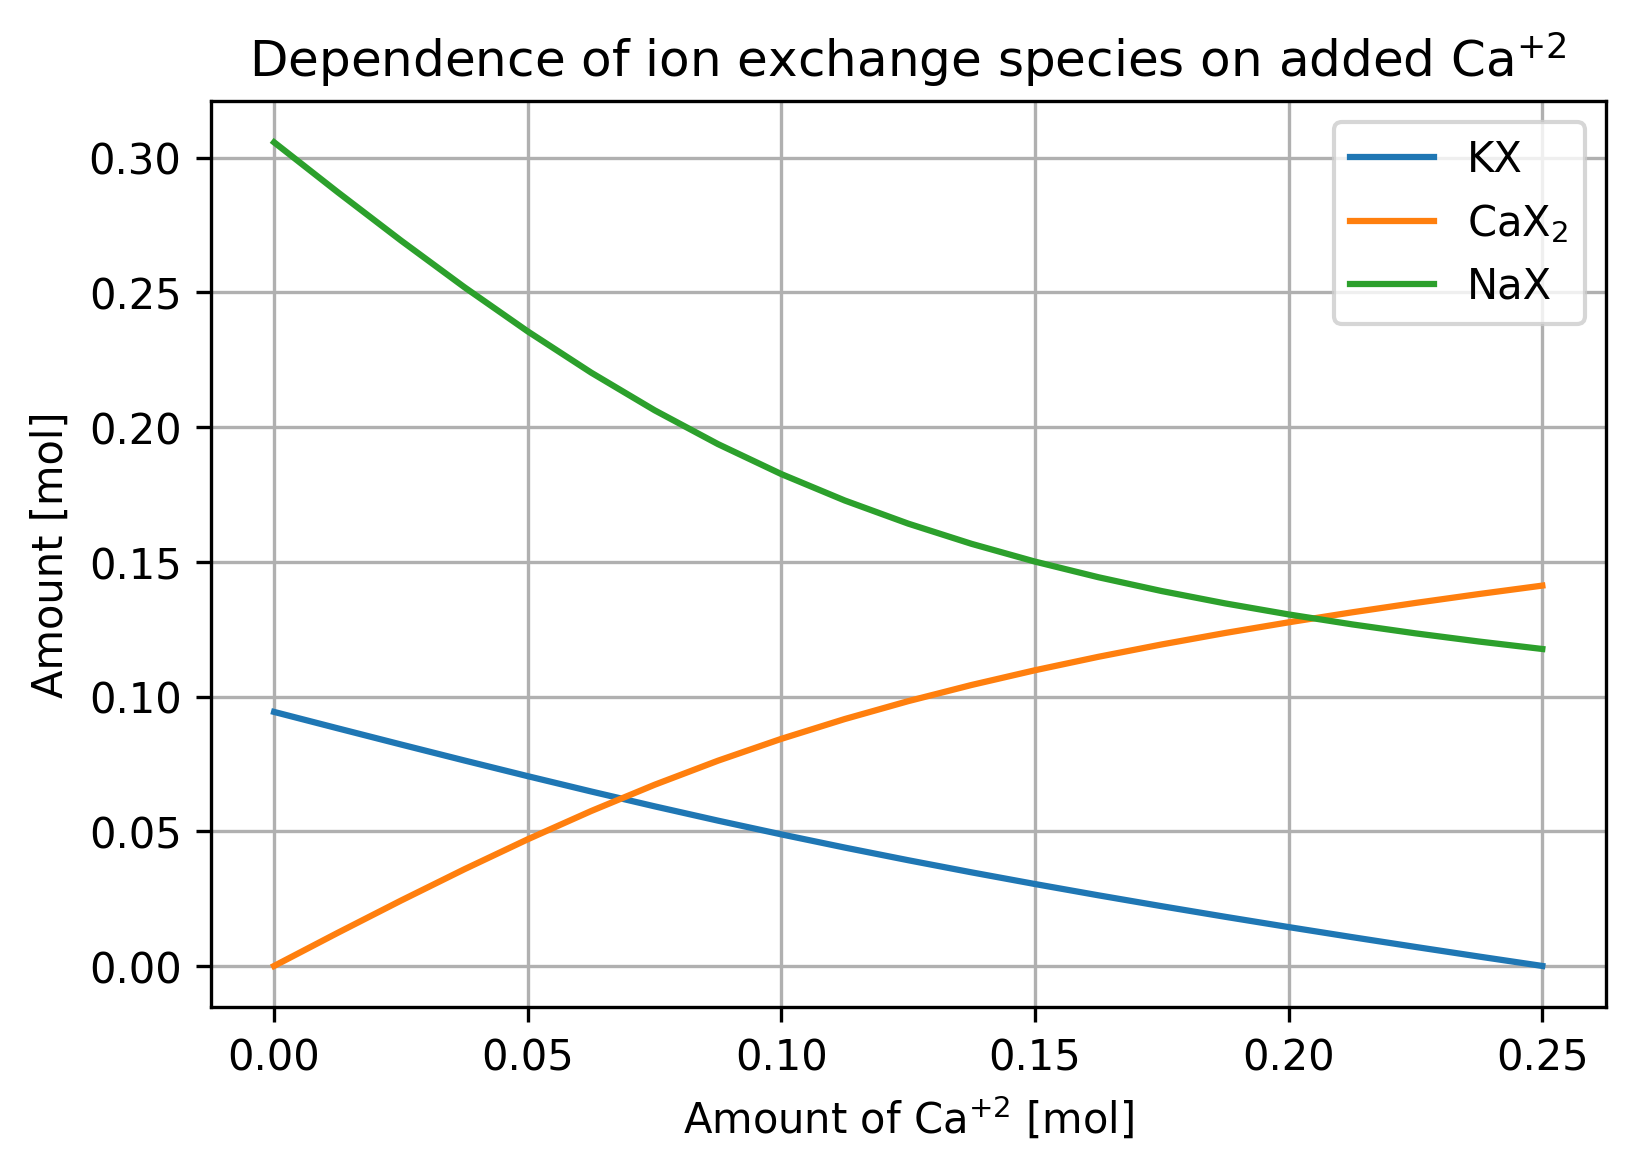

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 300

plt.figure()
plt.plot(df["amount_Ca"], df["amount_KX"]  , label="KX"  , color='C0')
plt.plot(df["amount_Ca"], df["amount_CaX2"], label=r"CaX$_2$", color='C1')
plt.plot(df["amount_Ca"], df["amount_NaX"] , label="NaX" , color='C2')
plt.legend(loc="best")
plt.xlabel(r'Amount of Ca$^{+2}$ [mol]')
plt.ylabel(f'Amount [mol]')
plt.title(r'Dependence of ion exchange species on added Ca$^{+2}$')
plt.grid()

We also depict the dependence of aqueous ions amounts on the growing Ca<sup>+2</sup> amount.

KeyError: 'amount(Na+)'

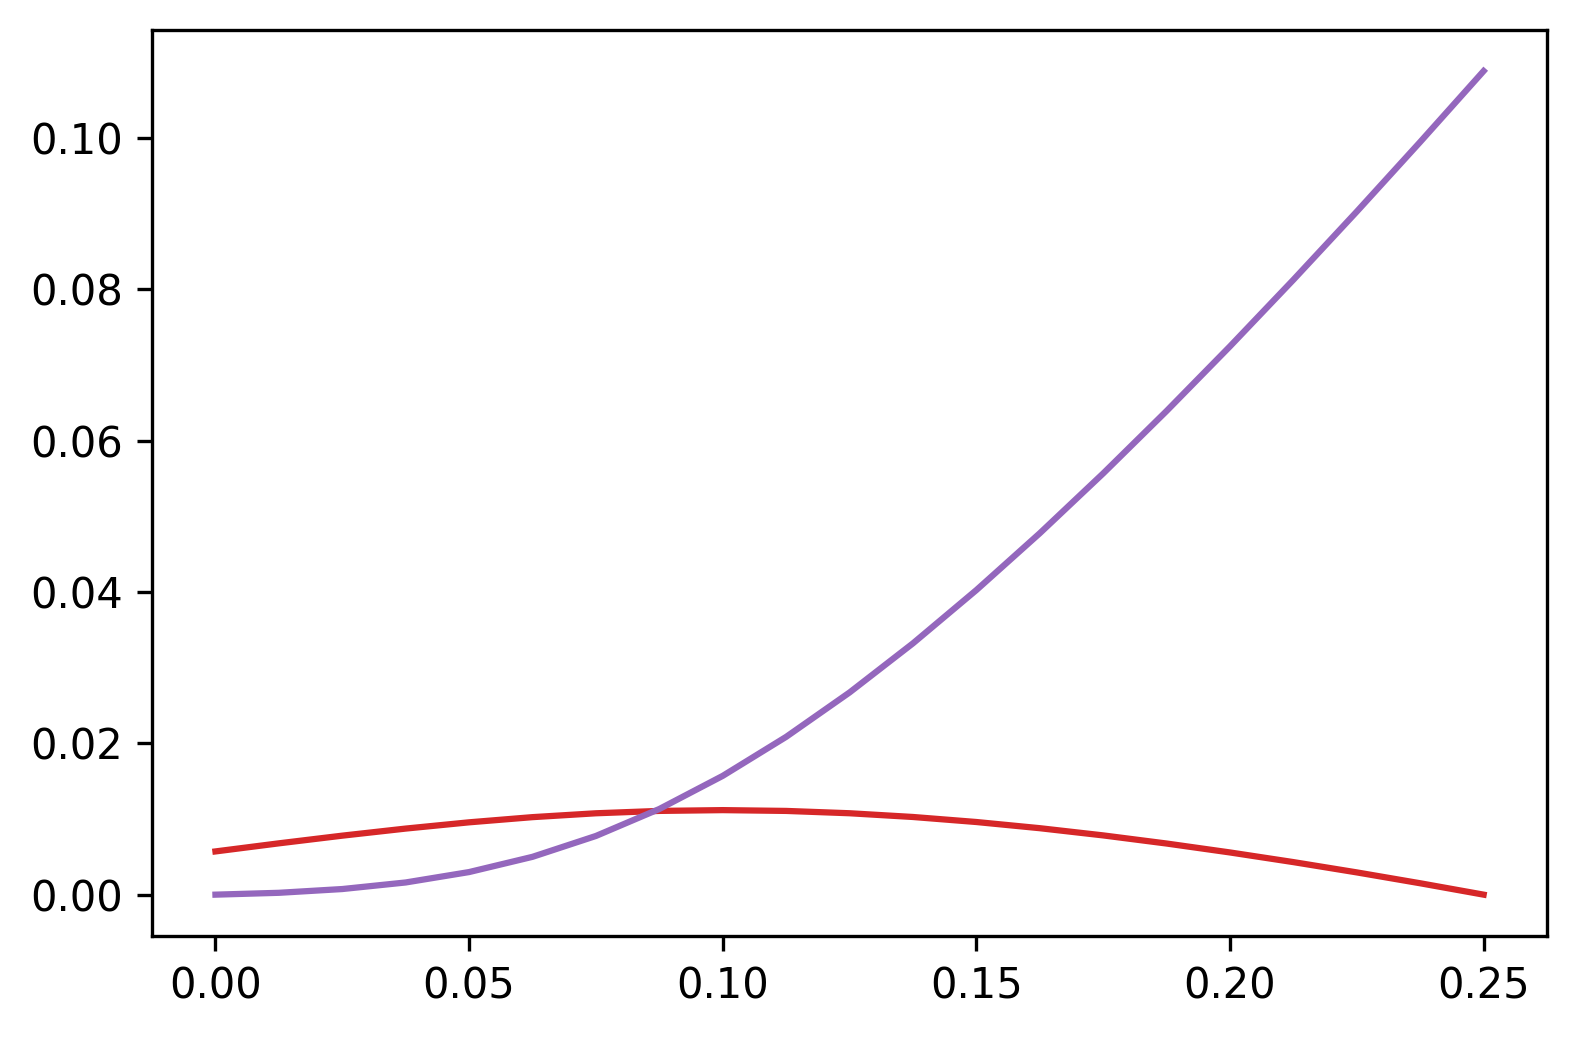

In [20]:
plt.figure()
plt.plot(df["amount_Ca"], df["amount_K+"] , label=r"K$^+$"  , color='C3')
plt.plot(df["amount_Ca"], df["amount_Ca+2"], label=r"Ca$^{+2}$", color='C4')
plt.plot(df["amount_Ca"], df["amount_Na+"], label=r"Na$^+$", color='C5')
plt.legend(loc="best")
plt.xlabel(r'Amount of Ca$^{+2}$ [mol]')
plt.ylabel(f'Amount [mol]')
plt.title(r'Dependence of the solute ions on added Ca$^{+2}$')
plt.grid()

Finally, we present the dependence of pH levels on changing values of Ca<sup>+2</sup> amount.

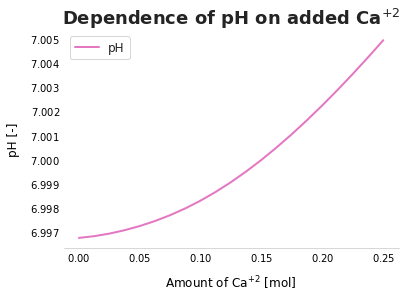

In [6]:
plt.figure()
plt.plot(df["amount_Ca"], df["pH"], label='pH', color='C6')
plt.legend(loc="best")
plt.xlabel(r'Amount of Ca$^{+2}$ [mol]')
plt.ylabel(f'pH [-]')
plt.title(r'Dependence of pH on added Ca$^{+2}$')
plt.grid()


We'll use the [bokeh](https://bokeh.org/) plotting library next. First, we need to import it and initialize it to work with Jupyter Notebooks:

In [31]:
from bokeh.plotting import figure, show
from bokeh.models import HoverTool
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

We can now define our interactive plot of ion exchange species dependence on growing initial amount of Ca<sup>+2</sup>:

In [ ]:
hovertool = HoverTool()
hovertool.tooltips = [("amount(Ca)", "@amount_Ca mol"),
                      ("amoun(KX)", "@amount_KX mol"),
                      ("amount(CaX2)", "@amount_CaX2 mol"),
                      ("amount(NaX)", "@amount_NaX mol")]

p = figure(
    title="DEPENDENCE OF ION EXCHANGE SPECIES ON ADDED CA+2",
    x_axis_label=r'AMOUNT OF CA+2 [MOL]',
    y_axis_label='AMOUNT [MOL]',
    sizing_mode="scale_width")

p.add_tools(hovertool)

p.line("amount_Ca", "amount_KX", legend_label="KX", line_width=5, line_cap="round", line_color="midnightblue", source=df)
p.line("amount_Ca", "amount_CaX2", legend_label=r"CaX2", line_width=5, line_cap="round", line_color="deeppink", source=df)
p.line("amount_Ca", "amount_NaX", legend_label="NaX", line_width=5, line_cap="round", line_color="green", source=df)
p.legend.location = 'bottom_right'

show(p)